# Packages

In [5]:
import freenect
import cv2
import numpy as np
from numba import njit, prange
import math
import os
import sys
import time
import pickle
from pathlib import Path
import tifffile as tiff
import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib import animation, rc
rc('animation', html='jshtml')

from IPython.display import HTML
from collections import deque
from tqdm.notebook import tqdm
from behavior_functions import *
from hmmlearn import hmm

from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, median_filter

### Additional infos

- If a gif is needed, screenshots of a code snipped dating back to 13-12-23 can be found and used

# Dataset_list creation

In [6]:
# Behavior folder in which all sessions are.

behavior_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior"

# session_keywords and mouse_keywords are lists of form ['S1', 'S2', 'S5'] or ['M29', 'M33', 'M37'], respectively.
# It can also be "all" if all sessions and mice are selected for analysis.
session_keywords = ["S5", "S6"]
mouse_keywords = "all"

In [7]:
dataset_list = dataset_paths(behavior_path, session_keywords, mouse_keywords, verbose = True)
print("Number of datasets: " ,len(dataset_list))

Mouse keywords:  ['M28', 'M29', 'M33', 'M37', 'M38', 'M39', 'M42']
Session keywords:  ['S5', 'S6']
Number of datasets:  14


In [ ]:
coords = []
for i in range(len(dataset_list)):
    coords.append(select_center(dataset_list[i] + "/video.avi", verbose=False))
    
for i in tqdm(range(len(dataset_list)), desc="Batch cropping"):
    crop_video_and_depth(dataset_list[i], coords[i])

In [23]:
for dataset_path in tqdm(dataset_list):
    find_background_mode(dataset_path, verbose = False)
    substract_background_with_array(dataset_path)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/18878 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/bg_sub_cropped_video.avi


  0%|          | 0/18879 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(len(dataset_list))):
    binarize_video(dataset_list[i])

In [10]:
coords2 = compute_centroids(dataset_list[0])

  0%|          | 0/2303 [00:00<?, ?it/s]

In [ ]:
for i in range(len(dataset_list)):
    save_mask_depth(dataset_list[i])

In [12]:
z = obtain_depth(dataset_list[0])

Error: Could not open depth video file.


OpenCV: Couldn't read video stream from file "/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/depth_mask.avi"
[ERROR:0@1278.253] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/depth_mask.avi in function 'icvExtractPattern'




In [10]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter1d(arr, sigma):
    return gaussian_filter1d(arr, sigma)

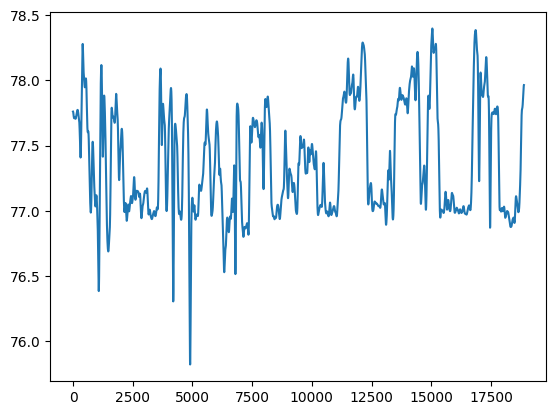

In [11]:
filt = apply_gaussian_filter1d(z, 20)
plt.plot(filt)
plt.show()

In [77]:
x,y,z = apply_gaussian_filter1d(coords2[:,0], 20), apply_gaussian_filter1d(coords2[:,1], 20), apply_gaussian_filter1d(z, 20)

In [97]:
a = count_pixels(dataset_list[0])

  0%|          | 0/18879 [00:00<?, ?it/s]

# tests

In [64]:
regression = predicted_y-np.min(predicted_y)

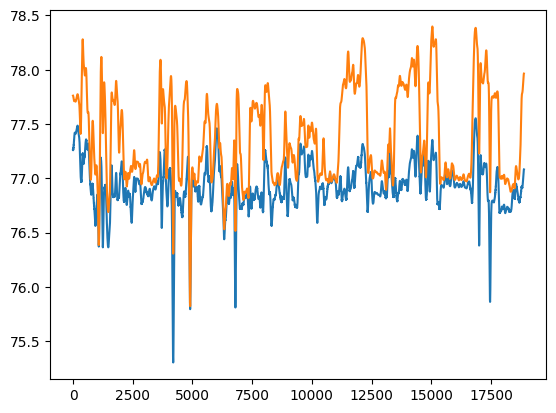

In [65]:
plt.plot(z-regression)
plt.plot(filt)

In [94]:
new_z = detrend_linear2d(x,y,z)

# Dataset processing

In [22]:
coords = []
for i in range(len(dataset_list)):
    if i > 0:
        break
    # Premake rectangles to crop
    coords.append(select_center(dataset_list[i] + "/video.avi", verbose=False))
    
for i in tqdm(range(len(dataset_list)), desc="Batch cropping"):
    if i>0:
        break
    # crop (with premade rectangles in coords)
    crop_video_and_depth(dataset_list[i], coords[i])
    
    # Substract background
    find_background_mode(dataset_list[i], verbose = False)
    substract_background_with_array(dataset_list[i])
    
    # Binarize
    binarize_video(dataset_list[i])
    
    # Saving video mask to use with depth and coords
    save_mask_depth(dataset_list[i])
    
    # Computing centroids
    xy_coords = compute_centroids(dataset_list[i])
    
    # Obtaining depth for z
    z_coord = obtain_depth(dataset_list[i])
    
    # Filter and combine x,y and z
    x,y,z = gaussian_filter1d(coords2[:,0], 20), gaussian_filter1d(coords2[:,1], 20), gaussian_filter1d(z_coord, 20)
    coords = np.column_stack((x, y, z))
    
    del xy_coords, z_coord, x, y, z
    
    # saving coordinate dictionary with pickle
    coords_dict = {}
    coords_dict['coords'] = coords
    
    folderpath = Path(dataset_list[i]).parent
    metadatapath = folderpath.joinpath("metadata.pkl")
    
    save_dict(str(metadatapath), coords_dict)
    

Batch cropping:   0%|          | 0/14 [00:00<?, ?it/s]

Processing video:   0%|          | 0/18879 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/cropped_video.avi


Transforming depth to video space:   0%|          | 0/18879 [00:00<?, ?it/s]

Processing depth:   0%|          | 0/18879 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/cropped_depth.avi


  0%|          | 0/18878 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/bg_sub_cropped_video.avi


0it [00:00, ?it/s]

IndexError: cannot do a non-empty take from an empty axes.